# Epigenome-Wide Association Study (EWAS) to Train an SVM Classifier

In this notebook, we will:

* Compare mechanisms by which transient exposure to nuclear reprogramming factors produces rejuvenates skin fibroblasts and vein endothelial cells.

* Classify patients in treatment and control groups using an SVM classifier based on DNA methylation levels.

* Evaluate performance using a confusion matrix.


Data used in notebook derived from: [Sarkar, T. J.; Quarta, M.; Mukherjee, S.; Colville, A.; Paine, P.; Doan, L.; Tran, C. M.; Chu, C. R.; Horvath, S.; Qi, L. S.; Bhutani, N.; Rando, T. A.; Sebastiano, V. Transient Non-Integrative Expression of Nuclear Reprogramming Factors Promotes Multifaceted Amelioration of Aging in Human Cells. Nature Communications 2020, 11 (1), 1545.](https://doi.org/10.1038/s41467-020-15174-3)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix

## Identify ($n = 500$) most significant CpGs determined by EWAS

* We've run EWAS (a bioinformatics algorithm) to sort CpG sites by differential DNA methylation between the treatment and control groups.

* In `data/glint_ewas_results_top10k.txt`, we list these CpGs (with additional metadata) in order of descending significance.

In [2]:
n = 500
CpGs = pd.read_csv("data/glint_ewas_results_top10k.txt", usecols=[0])   # Load only CpG names
top_CpGs = CpGs.iloc[0:n,].values.flatten()                             # Isolate the top 500 most significant CpGs

print("Top 500 Most Significant CpGs by EWAS:")
print()
print(top_CpGs)

Top 500 Most Significant CpGs by EWAS:

['cg13502023' 'cg23384863' 'cg00320765' 'cg24259463' 'cg04223956'
 'cg03407966' 'cg07403374' 'cg10122230' 'cg24603972' 'cg17526578'
 'cg05619202' 'cg04105597' 'cg22278294' 'cg12613081' 'cg00056325'
 'cg20903486' 'cg03414654' 'cg19323261' 'cg08235465' 'cg08277137'
 'cg02518948' 'cg02728857' 'cg11915312' 'cg20169734' 'cg16236275'
 'cg27053817' 'cg06429705' 'cg22079598' 'cg21940735' 'cg14011835'
 'cg26093964' 'cg06012428' 'cg12279288' 'cg00253428' 'cg19284838'
 'cg06860951' 'cg20309677' 'cg21200554' 'cg27345785' 'cg07774612'
 'cg04148515' 'cg09332438' 'cg15555000' 'cg14124194' 'cg11549294'
 'cg08700083' 'cg27198040' 'cg20407675' 'cg12312899' 'cg22723023'
 'cg06763538' 'cg09032791' 'cg19294038' 'cg06530743' 'cg14310198'
 'cg13265572' 'cg08573409' 'cg19275008' 'cg16614313' 'cg10581129'
 'cg19119393' 'cg08006738' 'cg12882383' 'cg16291587' 'cg04876597'
 'cg23991504' 'cg17130544' 'cg26334035' 'cg13952825' 'cg10626536'
 'cg01634612' 'cg03995951' 'cg080890

## Load DNA methylation data from GEO GSE142439

* DNA methylation levels corresponding to hundreds of thousands of CpG sites are included in the `Gene Expression Omnibus`, a repository of published genomic and epigenomic data

In [3]:
# This cell may take a minute to run...

# URL to GEO GSE142439 data set
data_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE142nnn/GSE142439/matrix//GSE142439_series_matrix.txt.gz'

# First 71 rows include metadata; all remaining rows include DNA methylation levels at each CpG
methyl = pd.read_csv(data_url, sep='\t', skiprows=71, index_col=0)
meta_data_backup = pd.read_csv(data_url, sep='\t', skiprows=40, index_col=0, nrows=3)


In [4]:
# Rows correspond to CpG sites; columns correspond to subjects
methyl.head()

,GSM4227385,GSM4227386,GSM4227387,GSM4227388,GSM4227389,GSM4227390,GSM4227391,GSM4227392,GSM4227393,GSM4227394,GSM4227395,GSM4227396,GSM4227397,GSM4227398,GSM4227399,GSM4227400
ID_REF,,,,,,,,,,,,,,,,
cg00000029,0.192582,0.229640,0.084506,0.102028,0.202294,0.170894,0.185225,0.229188,0.192410,0.152512,0.806773,0.865000,0.358765,0.366739,0.446669,0.433033
cg00000103,0.050515,0.040341,0.329022,0.189790,0.341425,0.341412,0.257052,0.240811,0.068477,0.046939,0.399574,0.466977,0.142422,0.062342,0.451088,0.469305
cg00000109,0.617563,0.642911,0.612092,0.488234,0.814250,0.836173,0.579529,0.590639,0.757969,0.800498,0.816367,0.875951,0.802504,0.770053,0.842257,0.827739
cg00000155,0.896258,0.914563,0.882052,0.908893,0.890299,0.884905,0.917016,0.885932,0.861848,0.882332,0.905635,0.875706,0.859308,0.851752,0.902935,0.928643
cg00000158,0.912854,0.917489,0.905442,0.906985,0.886896,0.823321,0.916827,0.929487,0.823668,0.857262,0.929702,0.892139,0.836527,0.820506,0.885229,0.902024


In [5]:
# Rows correspond to various metadata; columns correspond to subjects (before and after treatment)
meta_data_backup.head()

,individual: 1,individual: 1.1,individual: 2,individual: 2.1,individual: 3,individual: 3.1,individual: 4,individual: 4.1,individual: 5,individual: 5.1,individual: 6,individual: 6.1,individual: 7,individual: 7.1,individual: 8,individual: 8.1
!Sample_characteristics_ch1,,,,,,,,,,,,,,,,
!Sample_characteristics_ch1,age: 61,age: 61,age: 61,age: 61,age: 69,age: 69,age: 67,age: 67,age: 48,age: 48,age: 47,age: 47,age: 49,age: 49,age: 49,age: 49
!Sample_characteristics_ch1,cell type: skin fibroblasts,cell type: skin fibroblasts,cell type: skin fibroblasts,cell type: skin fibroblasts,cell type: skin fibroblasts,cell type: skin fibroblasts,cell type: skin fibroblasts,cell type: skin fibroblasts,cell type: vein endothelial cells,cell type: vein endothelial cells,cell type: vein endothelial cells,cell type: vein endothelial cells,cell type: vein endothelial cells,cell type: vein endothelial cells,cell type: vein endothelial cells,cell type: vein endothelial cells
!Sample_characteristics_ch1,treatmentstatus: Normal,treatmentstatus: Treated,treatmentstatus: Normal,treatmentstatus: Treated,treatmentstatus: Normal,treatmentstatus: Treated,treatmentstatus: Normal,treatmentstatus: Treated,treatmentstatus: Normal,treatmentstatus: Treated,treatmentstatus: Normal,treatmentstatus: Treated,treatmentstatus: Normal,treatmentstatus: Treated,treatmentstatus: Normal,treatmentstatus: Treated


## Isolate DNA methylation data from top 500 CpGs from fibroblasts and endothelial cells

In [6]:
meta_data = meta_data_backup.copy()
meta_data.columns = methyl.columns                  # Name metadata columns so they match methylation columns
meta_data.index = ['age', 'cell', 'treatment']      # The only metadata we care about are age, cell type, and group (normal or treated)
meta_data = meta_data.T

# Remove superfluous text
meta_data['age'] = meta_data['age'].str.replace('age: ','')
meta_data['cell'] = meta_data['cell'].str.replace('cell type: ','')
meta_data['treatment'] = meta_data['treatment'].str.replace('treatmentstatus: ','')

meta_data  # Much easier to interpret!

,age,cell,treatment
GSM4227385,61,skin fibroblasts,Normal
GSM4227386,61,skin fibroblasts,Treated
GSM4227387,61,skin fibroblasts,Normal
GSM4227388,61,skin fibroblasts,Treated
GSM4227389,69,skin fibroblasts,Normal
GSM4227390,69,skin fibroblasts,Treated
GSM4227391,67,skin fibroblasts,Normal
GSM4227392,67,skin fibroblasts,Treated
GSM4227393,48,vein endothelial cells,Normal
GSM4227394,48,vein endothelial cells,Treated


In [7]:
# Isolate CpG methylation data from fibroblast samples
meta_fibroblast = meta_data[meta_data["cell"] == "skin fibroblasts"]
all_IDs_fibroblasts = meta_fibroblast["treatment"].index.tolist()
norm_IDs_fibroblasts = meta_fibroblast[meta_fibroblast["treatment"] == "Normal"].index.tolist()
treat_IDs_fibroblasts = meta_fibroblast[meta_fibroblast["treatment"] == "Treated"].index.tolist()
methyl_500_fibroblasts = methyl.loc[top_CpGs,all_IDs_fibroblasts]

# Isolate CpG methylation data from endothelial cell samples
meta_endothelial = meta_data[meta_data["cell"] == "vein endothelial cells"]
all_IDs_endothelial = meta_endothelial["treatment"].index.tolist()
norm_IDs_endothelial = meta_endothelial[meta_endothelial["treatment"] == "Normal"].index.tolist()
treat_IDs_endothelial = meta_endothelial[meta_endothelial["treatment"] == "Treated"].index.tolist()
methyl_500_endothelial = methyl.loc[top_CpGs, all_IDs_endothelial]

In [8]:
norm_500_fibroblasts = methyl_500_fibroblasts.loc[:, norm_IDs_fibroblasts]
treat_500_fibroblasts = methyl_500_fibroblasts.loc[:, treat_IDs_fibroblasts]

norm_500_endothelial = methyl_500_endothelial.loc[:, norm_IDs_endothelial]
treat_500_endothelial = methyl_500_endothelial.loc[:, treat_IDs_endothelial]

print("Pre-treatment DNA methylation in fibroblast samples: ")
print()
print(norm_500_fibroblasts)
print()
print()
print("Post-treatment DNA methylation in fibroblast samples: ")
print()
print(treat_500_fibroblasts)
print()
print()
print("Pre-treatment DNA methylation in endothelial cell samples: ")
print()
print(norm_500_endothelial)
print()
print()
print("Post-treatment DNA methylation in endothelial cell samples: ")
print()
print(treat_500_endothelial)

Pre-treatment DNA methylation in fibroblast samples: 

            GSM4227385  GSM4227387  GSM4227389  GSM4227391
ID_REF                                                    
cg13502023    0.781714    0.781551    0.486792    0.660471
cg23384863    0.784160    0.706414    0.889465    0.733214
cg00320765    0.841218    0.692161    0.732697    0.504735
cg24259463    0.774138    0.697678    0.818152    0.696732
cg04223956    0.926845    0.900712    0.883346    0.921207
...                ...         ...         ...         ...
cg05945315    0.801197    0.838241    0.786329    0.756259
cg25771505    0.661907    0.584148    0.812583    0.678943
cg19462364    0.894552    0.913620    0.890720    0.914830
cg05982597    0.899010    0.873460    0.888925    0.815089
cg01098010    0.806607    0.777902    0.692122    0.547754

[500 rows x 4 columns]


Post-treatment DNA methylation in fibroblast samples: 

            GSM4227386  GSM4227388  GSM4227390  GSM4227392
ID_REF                               

## Visualization

/Users/ajspakow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/ajspakow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


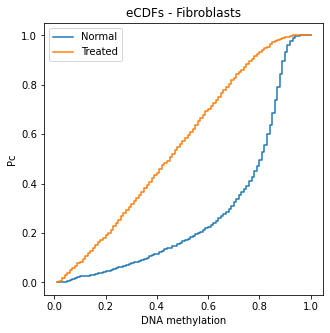

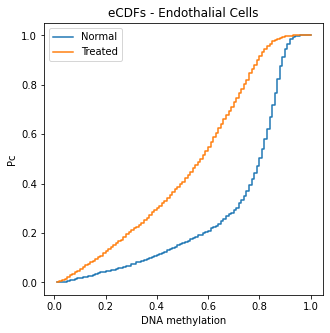

In [9]:
dx = 0.01
x = np.arange(0, 1+dx, dx)

# eCDFs – Fibroblasts
norm = np.histogram(norm_500_fibroblasts.values.flatten(), bins=x, density=True)[0]
c_norm = np.cumsum(norm * dx)
treat = np.histogram(treat_500_fibroblasts.values.flatten(), bins=x, density=True)[0]
c_treat = np.cumsum(treat * dx)

fig = plt.figure(figsize=(5, 5))
plt.step(x[1:], c_norm, label = "Normal")
plt.step(x[1:], c_treat, label = "Treated")
plt.xlabel("DNA methylation")
plt.ylabel("Pc")
plt.title("eCDFs - Fibroblasts")
plt.legend(loc="best")
fig.show()

# eCDFs – Endothelial Cels
norm = np.histogram(norm_500_endothelial.values.flatten(), bins=x, density=True)[0]
c_norm = np.cumsum(norm * dx)
treat = np.histogram(treat_500_endothelial.values.flatten(), bins=x, density=True)[0]
c_treat = np.cumsum(treat * dx)

fig = plt.figure(figsize=(5, 5))
plt.step(x[1:], c_norm, label = "Normal")
plt.step(x[1:], c_treat, label = "Treated")
plt.xlabel("DNA methylation")
plt.ylabel("Pc")
plt.title("eCDFs - Endothalial Cells")
plt.legend(loc="best")
fig.show()


## Train an SVM classifier on DNA methylation data in fibroblasts

In [10]:
# Fit SVM classifier to training data (using fibroblasts)
# Look into kernel, specify it, provide background
# Explain what the kernel is and how it works
# Kernel turns decision boundary into a linear classifier (show schematics in slides)

X_train = methyl_500_fibroblasts.values.T
y_train = [int(ID in treat_IDs_fibroblasts) for ID in all_IDs_fibroblasts]    # Encode "Normal" = 0; "Treated" = 1
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
print(clf)

SVC(kernel='linear')


## Evaluate Performace on DNA methylation data in endothelial cells

In [11]:
# Predict labels of test data (using endothelial cells)
X_test = methyl_500_endothelial.values.T
y_test = [int(ID in treat_IDs_endothelial) for ID in all_IDs_endothelial]    # Encode "Normal" = 0; "Treated" = 1
y_predict = clf.predict(X_test)

# Calculate prediction accuracy and generate confusion matrix
print("Accuracy: " + str(clf.score(X_test, y_test)))
print()
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_predict))

Accuracy: 1.0

Confusion Matrix: 
[[4 0]
 [0 4]]


When trained on fibroblasts and tested on endothelial cells, the SVM classifier was able to identify normal and treated subjects with perfect accuracy.

Therefore, the way that nuclear reprogramming factors affect DNA methylation in skin fibroblasts and vein endothelial cells may be similar!